### Проект оценки влияния условий жизни учащихся на успеваемость по математике.

С помощью собранных данных о семье, качестве жизни, учебной нагрузке учащихся небходимо проверить связь этих условий жизни с результатами госэкзаменов по математике, чтобы на ранней стадии выявлять находящихся в группе риска студентов со слабой успеваемостью.

In [1]:
%load_ext autoreload
%aimport edatools.clean
%aimport edatools.analisys
%autoreload 1

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pd.options.display.max_columns = None

#### Дано

In [3]:
sample = pd.read_csv('stud_math.csv').convert_dtypes()
sample.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,<NA>,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,-6,yes,<NA>,no,4,3,4,3,6,30
1,GP,F,17,U,GT3,<NA>,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,-6,yes,yes,no,5,3,3,3,4,30
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,<NA>,no,yes,-6,yes,yes,<NA>,4,3,2,3,10,50
3,GP,F,15,U,GT3,T,4,2,health,<NA>,home,mother,1,3,0,no,yes,yes,yes,yes,-9,yes,yes,yes,3,2,2,5,2,75
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,-6,yes,no,no,4,3,2,5,4,50


#### Метаданные

Мы знаем структуру датасета и набор значений некоторых полей, поэтому выполним сначала простые преобразования.

Переименуем колонки.

In [4]:
columns = {
    'famsize'            : 'family_size',
    'Pstatus'            : 'parental_cohabitation',
    'Medu'               : 'mother_education',
    'Fedu'               : 'father_education',
    'Mjob'               : 'mother_job',
    'Fjob'               : 'father_job',
    'reason'             : 'choice_reason',
    'traveltime'         : 'travel_time',
    'studytime'          : 'extra_study',
    'schoolsup'          : 'school_support',
    'famsup'             : 'family_support',
    'studytime, granular': 'extra_study_granular',
    'famrel'             : 'family_relations',
    'goout'              : 'friends_time',
}
sample.rename(columns=columns, inplace=True)

И проверим соответствие данных наборам значений известных типов.

In [5]:
from edatools.clean import check_anomalies

In [6]:
# структура для проверки на ошибки или аномальные значения
check_actions = {
    'sex': {
        'restrict': ('F', 'M')
    },
    'address': {
        'restrict': ('U', 'R')
    },
    'family_size': {
        'restrict': ('LE3', 'GT3')
    },
    'parental_cohabitation': {
        'restrict': ('T', 'A')
    },
    'mother_education': {
        'restrict': (0, 1, 2, 3, 4)
    },
    'father_education': {
        'restrict': (0, 1, 2, 3, 4)
    },
    'mother_job': {
        'restrict': ('teacher', 'health', 'services', 'at_home', 'other')
    },
    'father_job': {
        'restrict': ('teacher', 'health', 'services', 'at_home', 'other')
    },
    'choice_reason': {
        'restrict': ('home', 'reputation', 'course', 'other')
    },
    'guardian': {
        'restrict': ('mother', 'father', 'other')
    },
    'travel_time': {
        'restrict': (1, 2, 3, 4)
    },
    'extra_study': {
        'restrict': (1, 2, 3, 4)
    },
    'failures': {
        'restrict': (0, 1, 2, 3)
    },
    'school_support': {
        'restrict': ('yes', 'no')
    },
    'family_support': {
        'restrict': ('yes', 'no')
    },
    'paid': {
        'restrict': ('yes', 'no')
    },
    'activities': {
        'restrict': ('yes', 'no')
    },
    'nursery': {
        'restrict': ('yes', 'no')
    },
    'higher': {
        'restrict': ('yes', 'no')
    },
    'internet': {
        'restrict': ('yes', 'no')
    },
    'romantic': {
        'restrict': ('yes', 'no')
    },
    'family_relations': {
        'restrict': (1, 2, 3, 4, 5)
    },
    'freetime': {
        'restrict': (1, 2, 3, 4, 5)
    },
    'friends_time': {
        'restrict': (1, 2, 3, 4, 5)
    },
    'health': {
        'restrict': (1, 2, 3, 4, 5)
    }
}

In [7]:
check_anomalies(sample, check_actions)

{'father_education': {40: 1}, 'family_relations': {-1: 1}}

Можно предположить, что эти аномалии — опечатки (значений `4` и `1` соответственно). Исправим их.

In [8]:
sample.father_education.replace(40, 4, inplace=True)
sample.family_relations.replace(-1, 1, inplace=True)

#### Очистка

Изучим оставшиеся поля

In [9]:
sample.loc[:, [name for name in sample.columns if name not in check_actions]].dtypes

school                  string
age                      Int64
extra_study_granular     Int64
absences                 Int64
score                    Int64
dtype: object

In [10]:
display(sample.school.value_counts(dropna=False))

GP    349
MS     46
Name: school, dtype: Int64

Поле с аббревиатурами школ выглядит корректно заполненным. Рассмотрим остальные числовые поля в части распределения и выбросов.

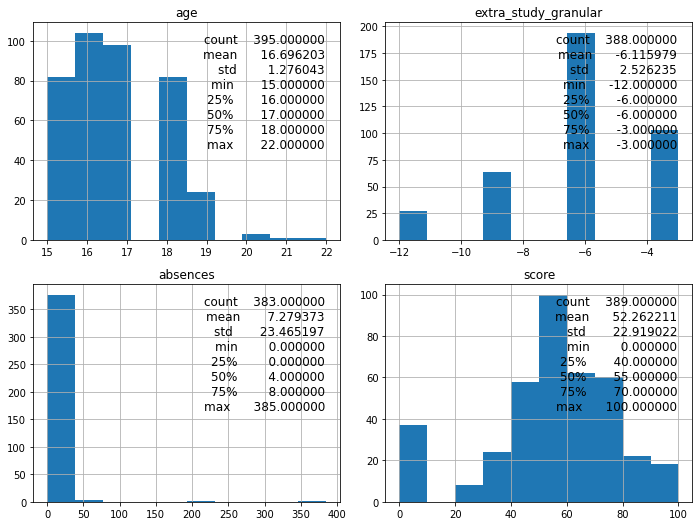

In [11]:
columns = ('age', 'extra_study_granular', 'absences', 'score')

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(6.4*1.5, 4.8*1.5),
                        constrained_layout=True)
for i in range(len(columns)):
    ax = sample[columns[i]].hist(ax=axs[i//2, i%2])
    ax.set_title(columns[i])
    ax.annotate(sample[columns[i]].describe().to_string(), (0.95, 0.95),
                xycoords='axes fraction', va='top', ha='right', size='large')

Данные о возрасте опрошенных укладываются в изучаемый диапазон (от 15 до 22 лет), однако оценим корреляцию возраста со здоровьем и результатами экзаменов, чтобы проверить предположение о том, что это неуспевающие ученики, и возраст заполнен корректно.

In [12]:
df = sample[['age', 'health', 'score']].astype('float64')

print('Корреляция возраста со здоровьем и экзаменационной оценкой')
display(df.corr().loc[['age'], :])

print('Статистические показатели "взрослых" учеников в сравнении со всей выборкой')
adults = df.loc[df.age > df.age.quantile(.75)].describe()
df.describe().join(adults, lsuffix='_all', rsuffix='_adults')

Корреляция возраста со здоровьем и экзаменационной оценкой


,age,health,score
age,1.0,-0.065946,-0.155726


Статистические показатели "взрослых" учеников в сравнении со всей выборкой


,age_all,health_all,score_all,age_adults,health_adults,score_adults
count,395.000000,380.000000,389.000000,29.000000,28.000000,26.000000
mean,16.696203,3.531579,52.262211,19.275862,3.428571,43.461538
std,1.276043,1.396019,22.919022,0.701862,1.345185,24.850321
min,15.000000,1.000000,0.000000,19.000000,1.000000,0.000000
25%,16.000000,3.000000,40.000000,19.000000,3.000000,40.000000
50%,17.000000,4.000000,55.000000,19.000000,3.000000,45.000000
75%,18.000000,5.000000,70.000000,19.000000,5.000000,58.750000
max,22.000000,5.000000,100.000000,22.000000,5.000000,90.000000


Действительно, успеваемость учеников старше 19 лет удовлетворительна. Интересно, что есть отрицательная корреляция между возрастом и экзаменационной оценкой во **всей** выборке.

Мы полагаем, что отдельные наблюдения в выборке — это результаты учебного года. В данных об отсутствиях есть явные выбросы превышающие количество учебных дней (их оценим как 260 будних дней в году минус 10 недель летних каникул, что есть _примерно_ 200 дн.). Обнулим эти выбросы и взглянем еще раз на распределение.

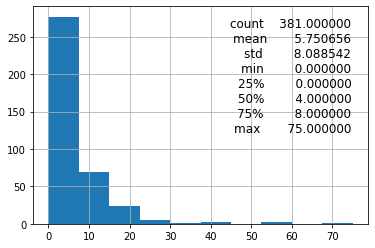

In [13]:
sample.absences = sample.absences.mask(sample.absences > 200)

ax = sample.absences.hist();
ax.annotate(sample.absences.describe().to_string(), (0.95, 0.95),
            xycoords='axes fraction', va='top', ha='right', size='large');

Теперь распределение пропущенных значений выглядит правдоподобно. Но для построения модели возможно потребуется избавиться от всех выбросов.

Экзаменационная оценка распределена нормально, но есть выбивающиеся из этого распределения околонулевые значения. Может ли это означать несданный экзамен по причине пропуска?

In [14]:
sample.loc[sample.score < 20, ['score', 'absences']].describe()

,score,absences
count,37.0,36.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


Наше наивное предположение не подтвердилось, и связи оценки с количеством пропущенных занятий нет. Оставим такие значения как есть.

#### Заполнение

Посмотрим на количество пропусков в данных.

In [15]:
display(pd.DataFrame({'NA': sample.isna().sum(), 'Unique': sample.nunique()}))
print('Total Dataset Rows:', len(sample))

,NA,Unique
school,0,2
sex,0,2
age,0,8
address,17,2
family_size,27,2
parental_cohabitation,45,2
mother_education,3,5
father_education,24,5
mother_job,19,5
father_job,36,5


Total Dataset Rows: 395


Переменная `score` — наша предсказываемая величина, поэтому удалим немногочисленные наблюдения с пропусками этой переменной из выборки.

In [16]:
sample.dropna(subset=['score'], inplace=True)

Уникальных значений в большинстве номинативных переменных немного, поэтому заполним пропуски наиболее встречающимися значениями. Под "наиболее встречающимися значениями" будем понимать те, которые составляют не менее 75% всех значений переменной.

In [17]:
from edatools.clean import most_common

In [18]:
columns = ('address', 'family_size', 'parental_cohabitation', 'mother_education',
           'father_education', 'mother_job', 'father_job', 'choice_reason', 'guardian',
           'travel_time', 'extra_study', 'failures', 'school_support', 'family_support',
           'paid', 'activities', 'nursery', 'extra_study_granular', 'higher', 'internet',
           'romantic', 'family_relations', 'freetime', 'friends_time', 'health')

values_to_fill = dict(most_common(sample, columns, threshold=.75))
print('Заполнены наиболее распространенные значения переменных:',
      ', '.join([f'{k} ({v})' for k,v in values_to_fill.items()]))

sample.fillna(values_to_fill, inplace=True)

Заполнены наиболее распространенные значения переменных: address (U), parental_cohabitation (T), failures (0), school_support (no), nursery (yes), higher (yes), internet (yes)


Для заполнения остальных значений мало данных, поэтому оставим их на текущем этапе как есть.

#### Связи

Рассмотрим корреляцию числовых переменных между собой, а также с оценкой по математике.

,age,mother_education,father_education,travel_time,extra_study,failures,extra_study_granular,family_relations,freetime,friends_time,health,absences,score
age,1.000000,-0.146736,-0.152148,0.073146,-0.018227,0.206279,0.018227,0.058768,0.016099,0.121115,-0.068103,0.171939,-0.155726
mother_education,-0.146736,1.000000,0.621981,-0.165838,0.081032,-0.240175,-0.081032,-0.003697,0.038265,0.072320,-0.048331,0.096016,0.213349
father_education,-0.152148,0.621981,1.000000,-0.132036,0.017306,-0.268048,-0.017306,-0.016791,-0.017263,0.050997,0.018624,0.037930,0.130923
travel_time,0.073146,-0.165838,-0.132036,1.000000,-0.105910,0.043067,0.105910,-0.032413,-0.026299,0.032629,-0.011724,-0.014284,-0.070559
extra_study,-0.018227,0.081032,0.017306,-0.105910,1.000000,-0.170933,-1.000000,0.039899,-0.125066,-0.053831,-0.079180,-0.065809,0.115741
failures,0.206279,-0.240175,-0.268048,0.043067,-0.170933,1.000000,0.170933,-0.029157,0.087781,0.100955,0.085078,0.063904,-0.337187
extra_study_granular,0.018227,-0.081032,-0.017306,0.105910,-1.000000,0.170933,1.000000,-0.039899,0.125066,0.053831,0.079180,0.065809,-0.115741
family_relations,0.058768,-0.003697,-0.016791,-0.032413,0.039899,-0.029157,-0.039899,1.000000,0.171165,0.072291,0.089074,-0.051829,0.055305
freetime,0.016099,0.038265,-0.017263,-0.026299,-0.125066,0.087781,0.125066,0.171165,1.000000,0.296338,0.064315,-0.068436,0.019026
friends_time,0.121115,0.072320,0.050997,0.032629,-0.053831,0.100955,0.053831,0.072291,0.296338,1.000000,-0.018026,0.038435,-0.129685


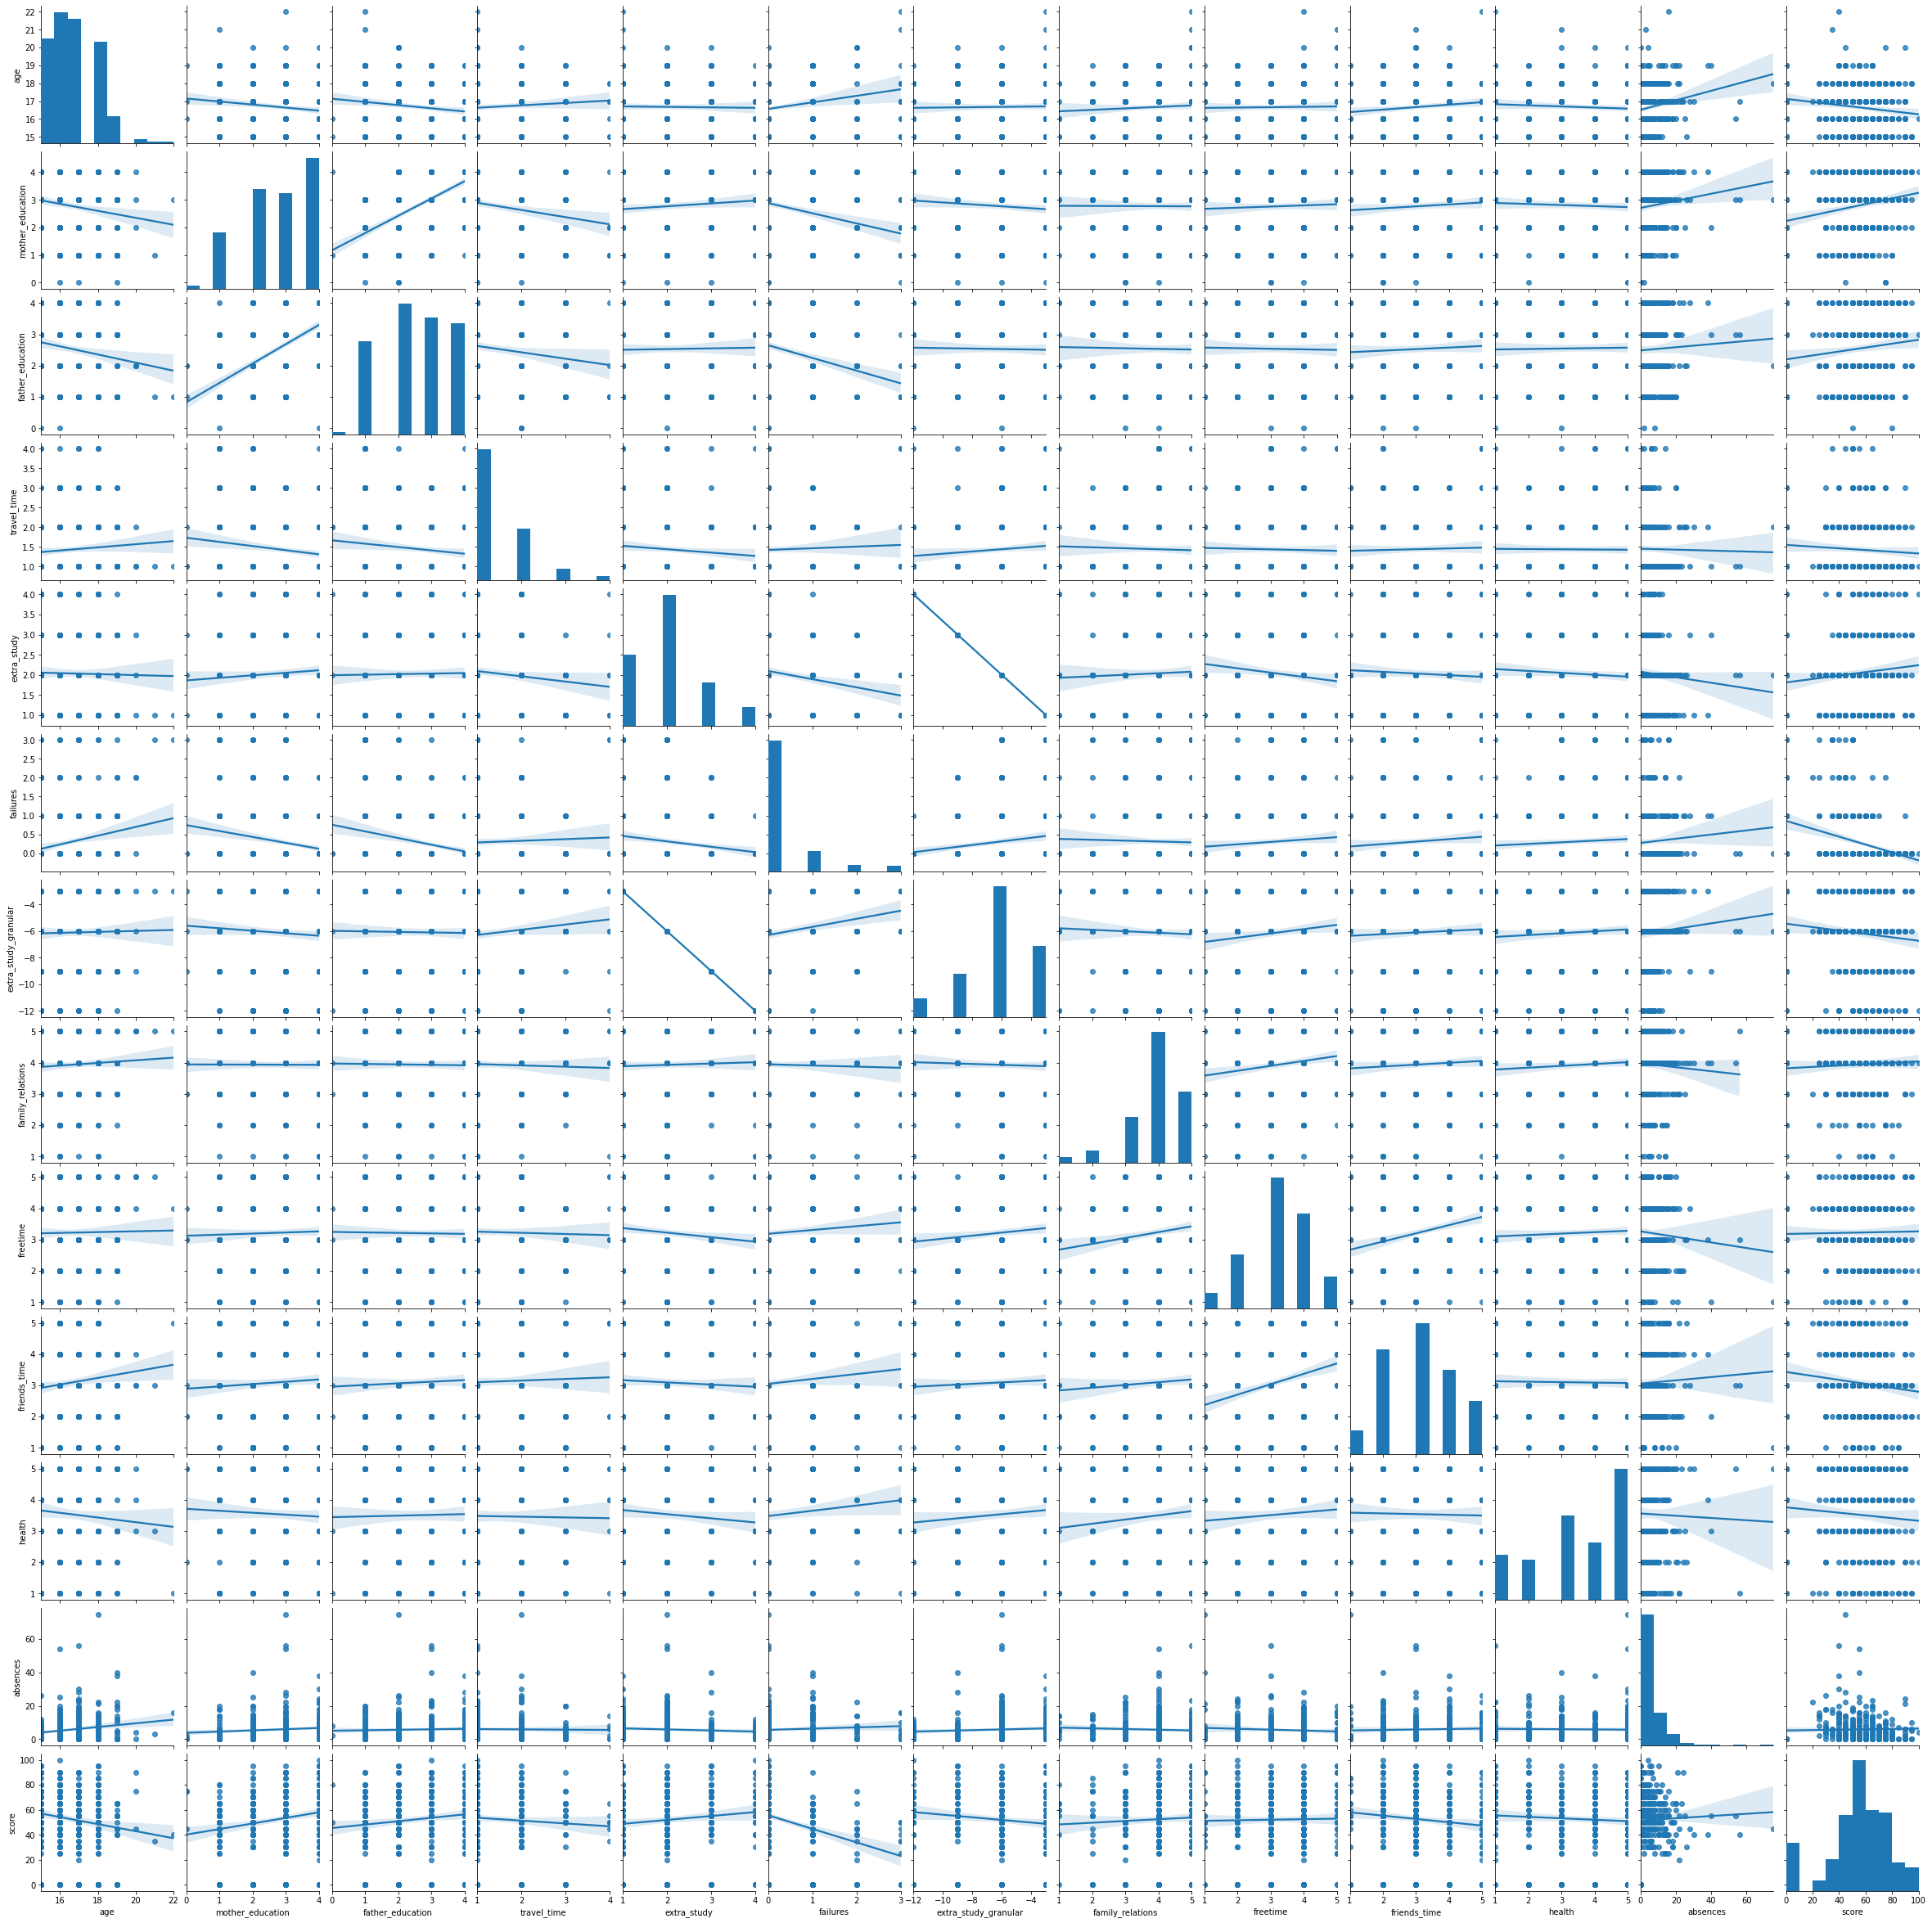

In [19]:
df = sample.select_dtypes('number').astype('float64')

sns.pairplot(df, kind='reg');
df.corr()

Поля `extra_study_granular` и `extra_study` скоррелированы полностью, поэтому первую можно исключить.

Заметна отрицательная корреляция возраста ученика с уровнем образования родителей, что может говорить о повышении общего уровня образование в регионе, где были собраны данные.

Еще нужно отметить сильную положительную корреляцию уровней образования родителей между собой. Это может свидетельствовать как о том, что долгосрочные отношения между людьми крепче при похожих интересах к окружающему миру, так и о том, что люди чаще сходятся в пределах одной рабочей среды (например, университета или колледжа, кухни ресторана или исследовательского института).

Видна также отрицательная корреляция уровня образования родителей и количества неудач ученика. Возможно, сказывается поддержка в семье. Стоит дополнительно рассмотреть взаимоотношение ученика с родителями. Странным кажется то, что ухудшение отношений ведет к потере свободного времени и времени, проведенного с друзьями.

Как отмечалось выше, наблюдается связь возраста с экзаменационными оценками — успеваемость учеников падает с возрастом. Интересно в этой связи, что ухудшается и здоровье, растет количество пропущенных занятий и внешкольных неудач, а потраченное на друзей время увеличивается. Это, конечно, свидетельствует о взрослении ученика и обострении связанных с этим проблем, о становлении человека общественного.

Отдельно рассмотрим связь успеваемости с остальными переменными выборки.

Вполне логична наблюдаемая положительная корреляция уровня образования родителей, семейного климата и дополнительных занятий со школьными оценками.

Заметна также отрицательная корреляция внеучебных неудач и проведенного с друзьями времени с успеваемостью ученика. Но сложно предположить, что именно является причиной в этой связи. И эти переменные следует рассматривать в контексте предположения о взрослении ученика.

Проверим теперь влияние номинативных переменных на исследуемую.

In [20]:
from edatools.analisys import stat_diff

In [21]:
nom_columns = sample.select_dtypes(['object', 'string']).columns
stat_diff_res = [stat_diff(sample, 'score', column) for column in nom_columns]
if (any(stat_diff_res)):
    print('Найдены статистически значимые различия для колонок:',
          ', '.join([k for k,v in zip(nom_columns, stat_diff_res) if v]))

Найдены статистически значимые различия для колонок: address, mother_job, higher, romantic


Влияние городской и загородной среды, стремления к получению высшего образования на успеваемость ученика объяснимо, но связь с романтическими отношениями удивительна.

#### Выводы

Данные достаточно чистые — только в столбце `absences` найдены выбросы.

Однако много пустых значений в большинстве столбцов, что в может являться следствием системных ошибок.

Для построение модели предлагается использовать наиболее важные номинативные переменные: `address`, `mother_job`, `higher`, `romantic`; исключить избыточное поле `extra_study_granular`.

In [22]:
model_columns = set(sample.columns)
model_columns -= set([k for k,v in zip(nom_columns, stat_diff_res) if not v])
model_columns -= set(['extra_study_granular'])

sample_for_model = sample.loc[:, model_columns]
sample_for_model

,extra_study,address,friends_time,absences,mother_job,mother_education,age,health,father_education,freetime,family_relations,failures,romantic,higher,score,travel_time
0,2,U,4,6,at_home,4,18,3,4,3,4,0,no,yes,30,2
1,2,U,3,4,at_home,1,17,3,1,3,5,0,no,yes,30,1
2,2,U,2,10,at_home,1,15,3,1,3,4,3,<NA>,yes,50,1
3,3,U,2,2,health,4,15,5,2,2,3,0,yes,yes,75,1
4,2,U,2,4,other,3,16,5,3,3,4,0,no,yes,50,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,2,U,4,<NA>,services,2,20,4,2,5,5,2,no,yes,45,1
391,1,U,5,3,services,3,17,2,1,4,2,0,no,yes,80,2
392,1,R,3,3,other,1,21,3,1,5,5,3,no,yes,35,1
393,1,R,1,0,services,3,18,5,2,4,4,0,no,yes,50,3
